In [197]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits=load_digits()

In [198]:
def sigmoid(x):
    return(1/(1+math.exp(-x)))

<Figure size 432x288 with 0 Axes>

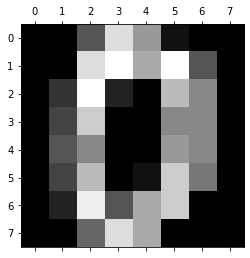

In [199]:
import pylab as pl
pl.gray()
pl.matshow(digits.images[0])
pl.show()

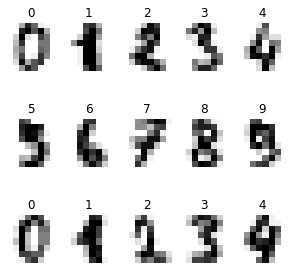

In [200]:
images_and_labels=list(zip(digits.images,digits.target))
plt.figure(figsize=(5,5))
for index,(image,label) in enumerate(images_and_labels[:15]):
    plt.subplot(3,5,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('%i' % label)

In [201]:
#Define variables
n_samples=len(digits.images)
print("Number of samples in the data set is :"+ str(n_samples))

x=digits.data
print("Shape of input matrix x is : "+str(x.shape))
y=digits.target
print("Shape of target vector y is :"+str(y.shape))


Number of samples in the data set is :1797
Shape of input matrix x is : (1797, 64)
Shape of target vector y is :(1797,)


In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [206]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [207]:
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)

In [208]:
Y_train_=np.zeros((y_train.shape[0],10))
Y_test_=np.zeros((y_test.shape[0],10))
for i in range(y_train.shape[0]):
    Y_train_[i,y_train[i]]=1
for i in range(y_test.shape[0]):
    Y_test_[i,y_test[i]]=1

In [209]:
# initialize parameters for deep neural networks
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1],layer_dims[l])*0.01
        parameters['b' + str(l)] = np.zeros((1,(layer_dims[l])))
        
        
    return parameters

In [210]:
def linear_forward(A, W, b):
    Z = np.dot(A,W)+b
    cache = (A, W, b)
    
    return Z, cache

In [211]:
def sigmoid_(Z):
    return 1/(1+np.exp(-Z))

def relu_(Z):
    return Z*(Z>0)

def drelu_(Z):
    return 1. *(Z>0)

def dsigmoid_(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid(Z):
    return sigmoid_(Z),Z

def relu(Z):
    return relu_(Z),Z

In [212]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [213]:
# implementation of forward propogation for L layer neural network
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2   
    for l in range(1, L):
        A_prev = A linear_activation_forward
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)
    #assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [243]:
# cost function
def compute_cost(AL, Y):
    m=Y.shape[0]
    cost = -(1/m)*np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost=np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [215]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[0]
    dW = (1/m)*np.dot(A_prev.T,dZ)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(dZ,W.T)
   
    
    return dA_prev, dW, db

In [216]:
def relu_backward(dA,activation_cache):
    return dA* drelu_(activation_cache)

In [217]:
def sigmoid_backward(dA,activation_cache):
    return dA* dsigmoid_(activation_cache)

In [218]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [219]:
# back propogation for L layers
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [220]:
#update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate)*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    return parameters

In [244]:
# N layer neural network
layers_dims=[64,60,10,10]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.931504
Cost after iteration 1000: 6.875852
Cost after iteration 2000: 6.811472
Cost after iteration 3000: 3.326810
Cost after iteration 4000: 3.100412
Cost after iteration 5000: 2.500692
Cost after iteration 6000: 1.931078
Cost after iteration 7000: 1.486417
Cost after iteration 8000: 0.969723
Cost after iteration 9000: 0.671733
Cost after iteration 10000: 0.489376
Cost after iteration 11000: 0.360760
Cost after iteration 12000: 0.278547
Cost after iteration 13000: 0.225562
Cost after iteration 14000: 0.187580
Cost after iteration 15000: 0.158792
Cost after iteration 16000: 0.135566
Cost after iteration 17000: 0.116761
Cost after iteration 18000: 0.101575
Cost after iteration 19000: 0.088802
Cost after iteration 20000: 0.078137
Cost after iteration 21000: 0.069213
Cost after iteration 22000: 0.061710
Cost after iteration 23000: 0.055294
Cost after iteration 24000: 0.049777
Cost after iteration 25000: 0.044988
Cost after iteration 26000: 0.040811
Cost after ite

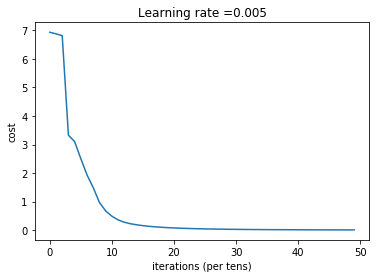

In [245]:
parameters = L_layer_model(X_train, Y_train_, layers_dims, num_iterations = 50000, print_cost = True)